[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Designing Nonlinear Kalman Filters

In [1]:
#format the book
%matplotlib inline
from __future__ import division, print_function
from book_format import load_style
load_style()

## Introduction

** Author's note: I was initially planning to have a design nonlinear chapter that compares various approaches. This may or may not happen, but for now this chapter has no useful content and I suggest not reading it. **

We see that the Kalman filter reasonably tracks the ball. However, as already explained, this is a silly example; we can predict trajectories in a vacuum with arbitrary precision; using a Kalman filter in this example is a needless complication.

### Kalman Filter with Air Drag

I will dispense with the step 1, step 2, type approach and proceed in a more natural style that you would use in a non-toy engineering problem. We have already developed a Kalman filter that does excellently at tracking a ball in a vacuum, but that does not incorporate the effects of air drag into the model. We know that the process model is implemented with $\textbf{F}$, so we will turn our attention to that immediately.

Notionally, the computation that $\textbf{F}$ computes is

$$x' = Fx$$

With no air drag, we had

$$
\mathbf{F} = \begin{bmatrix}
1 & \Delta t & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 \\
0 & 0 & 1 & \Delta t & \frac{1}{2}{\Delta t}^2 \\
0 & 0 & 0 & 1 & \Delta t \\
0 & 0 & 0 & 0 & 1
\end{bmatrix}
$$

which corresponds to the equations

$$ 
\begin{aligned}
x &= x + v_x \Delta t \\
v_x &= v_x \\
\\
y &= y + v_y \Delta t + \frac{a_y}{2} {\Delta t}^2 \\
v_y &= v_y + a_y \Delta t \\
a_y &= a_y
\end{aligned}
$$

From the section above we know that our new Euler equations must be

$$ 
\begin{aligned}
x &= x + v_x \Delta t \\
v_x &= v_x \\
\\
y &= y + v_y \Delta t + \frac{a_y}{2} {\Delta t}^2 \\
v_y &= v_y + a_y \Delta t \\
a_y &= a_y
\end{aligned}
$$

## Realistic 2D Position Sensors

The position sensor in the last example are not very realistic. In general there is no 'raw' sensor that provides (x,y) coordinates. We have GPS, but GPS already uses a Kalman filter to create a filtered output; we should not be able to improve the signal by passing it through another Kalman filter unless we incorporate additional sensors to provide additional information. We will tackle that problem later. 

Consider the following set up. In an open field we put two transmitters at a known location, each transmitting a signal that we can detect. We process the signal and determine  how far we are from that signal, with some noise. First, let's look at a visual depiction of that.

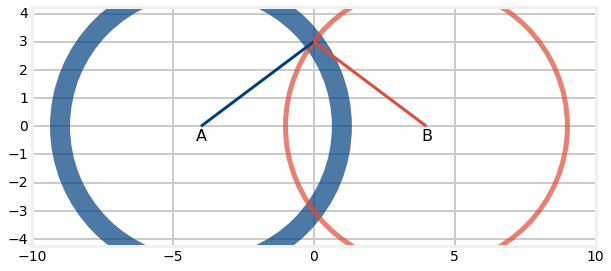

In [2]:
import matplotlib.pyplot as plt

circle1=plt.Circle((-4, 0), 5, color='#004080', 
                   fill=False, linewidth=20, alpha=.7)
circle2=plt.Circle((4, 0), 5, color='#E24A33', 
                   fill=False, linewidth=5, alpha=.7)

fig = plt.gcf()
ax = fig.gca()

plt.axis('equal')
plt.xlim((-10, 10))
plt.ylim((-10, 10))

plt.plot ([-4, 0], [0, 3], c='#004080')
plt.plot ([4, 0], [0, 3], c='#E24A33')
plt.text(-4, -.5, "A", fontsize=16, horizontalalignment='center')
plt.text(4, -.5, "B", fontsize=16, horizontalalignment='center')

ax.add_artist(circle1)
ax.add_artist(circle2)
plt.show()

Here I have attempted to show transmitter A, drawn in red, at (-4,0) and a second one B, drawn in blue, at (4,0). The red and blue circles show the range from the transmitters to the robot, with the width illustrating the effect of the $1\sigma$ angular error for each transmitter. Here I have given the blue transmitter more error than the red one. The most probable position for the robot is where the two circles intersect, which I have depicted with the red and blue lines. You will object that we have two intersections, not one, but we will see how we deal with that when we design the measurement function.

This is a very common sensor set up. Aircraft still use this system to navigate, where it is called DME (Distance Measuring Equipment). Today GPS is a much more common navigation system, but I have worked on an aircraft where we integrated sensors like this into our filter along with the GPS, INS, altimeters, etc. We will tackle what is called *multi-sensor fusion* later; for now we will just address this simple configuration.

The first step is to design our state variables. We will assume that the robot is traveling in a straight direction with constant velocity. This is unlikely to be true for a long period of time, but is acceptable for short periods of time. This does not differ from the previous problem - we will want to track the values for the robot's position and velocity. Hence,

$$\mathbf{x} = 
\begin{bmatrix}x\\v_x\\y\\v_y\end{bmatrix}$$

The next step is to design the state transition function. This also will be the same as the previous problem, so without further ado,

$$
\mathbf{x}' = \begin{bmatrix}1& \Delta t& 0& 0\\0& 1& 0& 0\\0& 0& 1& \Delta t\\ 0& 0& 0& 1\end{bmatrix}\mathbf{x}$$

The next step is to design the control inputs. We have none, so we set ${\mathbf{B}}=0$.

The next step is to design the measurement function $\mathbf{z} = \mathbf{Hx}$. We can model the measurement using the Pythagorean theorem.

$$
z_a = \sqrt{(x-x_A)^2 + (y-y_A)^2} + v_a\\[1em]
z_b = \sqrt{(x-x_B])^2 + (y-y_B)^2} + v_b
$$

where $v_a$ and $v_b$ are white noise.

We see an immediate problem. The Kalman filter is designed for linear equations, and this is obviously nonlinear. In the next chapters we will look at several ways to handle nonlinear problems in a robust way, but for now we will do something simpler. If we know the approximate position of the robot than we can linearize these equations around that point. I could develop the generalized mathematics for this technique now, but instead let me just present the worked example to give context to that development.

Instead of computing $\mathbf{H}$ we will compute the partial derivative of $\mathbf{H}$ with respect to the robot's position $\mathbf{x}$. You are probably familiar with the concept of partial derivative, but if not, it just means how $\mathbf{H}$ changes with respect to the robot's position. It is computed as the partial derivative of $\mathbf{H}$ as follows:

$$\frac{\partial \mathbf{h}}{\partial \mathbf{x}} = 
\begin{bmatrix}
\frac{\partial h_1}{\partial x_1} & \frac{\partial h_1}{\partial x_2} &\dots \\
\frac{\partial h_2}{\partial x_1} & \frac{\partial h_2}{\partial x_2} &\dots \\
\vdots & \vdots
\end{bmatrix}
$$

Let's work the first partial derivative. We want to find

$$\frac{\partial }{\partial x} \sqrt{(x-x_A)^2 + (y-y_A)^2}
$$

Which we compute as

$$
\begin{aligned}
\frac{\partial h_1}{\partial x} &= ((x-x_A)^2 + (y-y_A)^2))^\frac{1}{2} \\
&= \frac{1}{2}\times 2(x-x_a)\times ((x-x_A)^2 + (y-y_A)^2))^{-\frac{1}{2}} \\
&= \frac{x_r - x_A}{\sqrt{(x_r-x_A)^2 + (y_r-y_A)^2}} 
\end{aligned}
$$

We continue this computation for the partial derivatives of the two distance equations with respect to $x$, $y$, $dx$ and $dy$, yielding

$$\frac{\partial\mathbf{h}}{\partial\mathbf{x}}=
\begin{bmatrix}
\frac{x_r - x_A}{\sqrt{(x_r-x_A)^2 + (y_r-y_A)^2}} & 0 & 
\frac{y_r - y_A}{\sqrt{(x_r-x_A)^2 + (y_r-y_A)^2}} & 0 \\
\frac{x_r - x_B}{\sqrt{(x_r-x_B)^2 + (y_r-y_B)^2}} & 0 &
\frac{y_r - y_B}{\sqrt{(x_r-x_B)^2 + (y_r-y_B)^2}} & 0 \\
\end{bmatrix}
$$

That is pretty painful, and these are very simple equations. Computing the Jacobian can be extremely difficult or even impossible for more complicated systems. However, there is an easy way to get Python to do the work for you by using the SymPy module [1]. SymPy is a Python library for symbolic mathematics. The full scope of its abilities are beyond this book, but it can perform algebra, integrate and differentiate equations, find solutions to differential equations, and much more. We will use it to compute our Jacobian!

First, a simple example. We will import SymPy, initialize its pretty print functionality (which will print equations using LaTeX). We will then declare a symbol for NumPy to use.

In [3]:
import sympy
from sympy import init_printing
init_printing(use_latex='png')

phi, x = sympy.symbols('\phi, x')
phi

Notice how we use a latex expression for the symbol `phi`. This is not necessary, but if you do it will render as LaTeX when output. Now let's do some math. What is the derivative of $\sqrt{\phi}$?

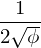

In [4]:
sympy.diff('sqrt(phi)')

We can factor equations.

In [5]:
sympy.factor('phi**3 -phi**2 + phi - 1')

SymPy has a remarkable list of features, and as much as I enjoy exercising its features we cannot cover them all here. Instead, let's compute our Jacobian.

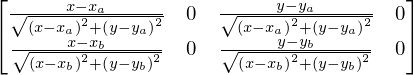

In [6]:
from sympy import symbols, Matrix
phi = symbols('\phi')
phi

x, y, xa, xb, ya, yb, dx, dy = symbols('x y x_a x_b y_a y_b dx dy')

H = Matrix([[sympy.sqrt((x-xa)**2 + (y-ya)**2)], 
            [sympy.sqrt((x-xb)**2 + (y-yb)**2)]])

state = Matrix([x, dx, y, dy])
H.jacobian(state)

In a nutshell, the entry (0,0) contains the difference between the x coordinate of the robot and transmitter A's x coordinate divided by the distance between the robot and A. (2,0) contains the same, except for the y coordinates of the robot and transmitters. The bottom row contains the same computations, except for transmitter B. The 0 entries account for the velocity components of the state variables; naturally the range does not provide us with velocity.

The values in this matrix change as the robot's position changes, so this is no longer a constant; we will have to recompute it for every time step of the filter.

If you look at this you may realize that this is just a computation of x/dist and y/dist, so we can switch this to a trigonometic form with no loss of generality:

$$\frac{\partial\mathbf{h}}{\partial\mathbf{x}}=
\begin{bmatrix}
-\cos{\theta_A} & 0 & -\sin{\theta_A} & 0 \\
-\cos{\theta_B} & 0 & -\sin{\theta_B} & 0
\end{bmatrix}
$$

However, this raises a huge problem. We are no longer computing $\mathbf{H}$, but $\Delta\mathbf{H}$, the change of $\mathbf{H}$. If we passed this into our Kalman filter without altering the rest of the design the output would be nonsense. Recall, for example, that we multiply $\mathbf{Hx}$ to generate the measurements that would result from the given estimate of $\mathbf{x}$ But now that $\mathbf{H}$ is linearized around our position it contains the *change* in the measurement function. 

We are forced, therefore, to use the *change* in $\mathbf{x}$ for our state variables. So we have to go back and redesign our state variables. 

>Please note this is a completely normal occurrence in designing Kalman filters. The textbooks present examples like this as *fait accompli*, as if it is trivially obvious that the state variables needed to be velocities, not positions. Perhaps once you do enough of these problems it would be trivially obvious, but at that point why are you reading a textbook? I find myself reading through a presentation multiple times, trying to figure out why they made a choice, finally to realize that it is because of the consequences of something on the next page. My presentation is longer, but it reflects what actually happens when you design a filter. You make what seem reasonable design choices, and as you move forward you discover properties that require you to recast your earlier steps. As a result, I am going to somewhat abandon my **step 1**, **step 2**, etc.,  approach, since so many real problems are not quite that straightforward.

If our state variables contain the velocities of the robot and not the position then how do we track where the robot is? We can't. Kalman filters that are linearized in this fashion use what is called a *nominal trajectory* - i.e. you assume a position and track direction, and then apply the changes in velocity and acceleration to compute the changes in that trajectory. How could it be otherwise? Recall the graphic showing the intersection of the two range circles - there are two areas of intersection. Think of what this would look like if the two transmitters were very close to each other - the intersections would be two very long crescent shapes. This Kalman filter, as designed, has no way of knowing your true position from only distance measurements to the transmitters. Perhaps your mind is already leaping to ways of working around this problem. If so, stay engaged, as later sections and chapters will provide you with these techniques. Presenting the full solution all at once leads to more confusion than insight, in my opinion. 

So let's redesign our *state transition function*. We are assuming constant velocity and no acceleration, giving state equations of
$$
\dot{x}' = \dot{x} \\
\ddot{x}' = 0 \\
\dot{y}' = \dot{y} \\
\dot{y}' = 0$$

This gives us the the *state transition function* of

$$
\mathbf{F} = \begin{bmatrix}0 &1 & 0& 0\\0& 0& 0& 0\\0& 0& 0& 1\\ 0& 0& 0& 0\end{bmatrix}$$

A final complication comes from the measurements that we pass in. $\mathbf{Hx}$ is now computing the *change* in the measurement from our nominal position, so the measurement that we pass in needs to be not the range to A and B, but the *change* in range from our measured range to our nominal position. 

There is a lot here to take in, so let's work through the code bit by bit. First we will define a function to compute $\frac{\partial\mathbf{h}}{\partial\mathbf{x}}$ for each time step.

In [7]:
from math import sin, cos, atan2

def H_of(pos, pos_A, pos_B):
    """ Given the position of our object at 'pos' in 2D, and two 
    transmitters A and B at positions 'pos_A' and 'pos_B', return 
    the partial derivative of H
    """

    theta_a = atan2(pos_a[1] - pos[1], pos_a[0] - pos[0])
    theta_b = atan2(pos_b[1] - pos[1], pos_b[0] - pos[0])

    return np.array([[0, -cos(theta_a), 0, -sin(theta_a)],
                     [0, -cos(theta_b), 0, -sin(theta_b)]])

Now we need to create our simulated sensor. 

In [8]:
from numpy.random import randn

class DMESensor(object):
    def __init__(self, pos_a, pos_b, noise_factor=1.0):
        self.A = pos_a
        self.B = pos_b
        self.noise_factor = noise_factor
        
    def range_of(self, pos):
        """ returns tuple containing noisy range data to A and B
        given a position 'pos'
        """
        
        ra = math.sqrt((self.A[0] - pos[0])**2 + (self.A[1] - pos[1])**2)
        rb = math.sqrt((self.B[0] - pos[0])**2 + (self.B[1] - pos[1])**2)
        
        return (ra + randn()*self.noise_factor, 
                rb + randn()*self.noise_factor)

Finally, we are ready for the Kalman filter code. I will position the transmitters at x=-100 and 100, both with y=-20. This gives me enough space to get good triangulation from both as the robot moves. I will start the robot at (0,0) and move by (1,1) each time step. 

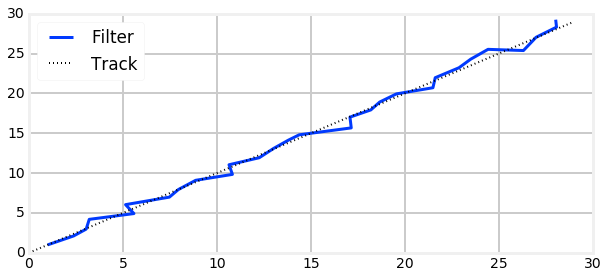

In [9]:
import code.book_plots as bp
from filterpy.kalman import KalmanFilter
import math
import numpy as np

pos_a = (100, -20)
pos_b = (-100, -20)

f1 = KalmanFilter(dim_x=4, dim_z=2)

f1.F = np.array ([[0, 1, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 0, 0, 0]], dtype=float)

f1.R *= 1.
f1.Q *= .1

f1.x = np.array([[1, 0, 1, 0]], dtype=float).T
f1.P = np.eye(4) * 5.

# initialize storage and other variables for the run
count = 30
xs, ys = [], []
pxs, pys = [], []

# create the simulated sensor
d = DMESensor(pos_a, pos_b, noise_factor=3.)

# pos will contain our nominal position since the filter does not
# maintain position.
pos = [0, 0]

for i in range(count):
    # move (1,1) each step, so just use i
    pos = [i, i]
    
    # compute the difference in range between the nominal track
    # and measured ranges
    ra,rb = d.range_of(pos)
    rx,ry = d.range_of((pos[0] + f1.x[0, 0], pos[1] + f1.x[2, 0]))
    z = np.array([[ra - rx], [rb - ry]])

    # compute linearized H for this time step
    f1.H = H_of (pos, pos_a, pos_b)

    # store stuff so we can plot it later
    xs.append(f1.x[0, 0]+i)
    ys.append(f1.x[2, 0]+i)
    pxs.append(pos[0])
    pys.append(pos[1])
    
    # perform the Kalman filter steps
    f1.predict()
    f1.update(z)

bp.plot_filter(xs, ys)
bp.plot_track(pxs, pys)
plt.legend(loc=2)
plt.show()

## Linearizing the Kalman Filter

Now that we have seen an example of linearizing the Kalman filter we are in a position to better understand the math. 

We start by assuming some function $\mathbf f$

## Example: A falling Ball

**author's note: ignore this section for now. **

In the **Designing Kalman Filters** chapter I first considered tracking a ball in a vacuum, and then in the atmosphere. The Kalman filter performed very well for vacuum, but diverged from the ball's path in the atmosphere. Let us look at the output; to avoid littering this chapter with code from that chapter I have placed it all in the file `ekf_internal.py'.

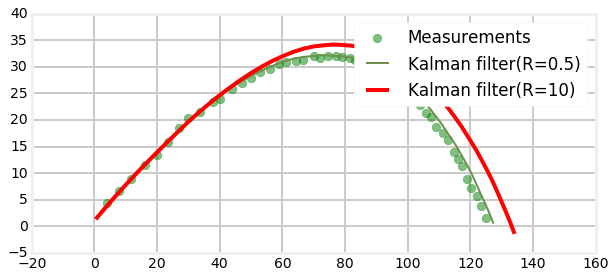

In [10]:
import code.ekf_internal as ekf
ekf.plot_ball()

We can artificially force the Kalman filter to track the ball by making $Q$ large. That would cause the filter to mistrust its prediction, and scale the kalman gain $K$ to strongly favor the measurments. However, this is not a valid approach. If the Kalman filter is correctly predicting the process we should not 'lie' to the filter by telling it there are process errors that do not exist. We may get away with that for some problems, in some conditions, but in general the Kalman filter's performance will be substandard.

Recall from the **Designing Kalman Filters** chapter that the acceleration is

$$a_x = (0.0039 + \frac{0.0058}{1+\exp{[(v-35)/5]}})*v*v_x \\
a_y = (0.0039 + \frac{0.0058}{1+\exp{[(v-35)/5]}})*v*v_y- g
$$

These equations will be *very* unpleasant to work with while we develop this subject, so for now I will retreat to a simpler one dimensional problem using this simplified equation for acceleration that does not take the nonlinearity of the drag coefficient into account:


$$\begin{aligned}
\ddot{y} &= \frac{0.0034ge^{-y/20000}\dot{y}^2}{2\beta} - g \\
\ddot{x} &= \frac{0.0034ge^{-x/20000}\dot{x}^2}{2\beta}
\end{aligned}$$

Here $\beta$ is the ballistic coefficient, where a high number indicates a low drag.

This is still nonlinear, so we need to linearize this equation at the current state point. If our state is position and velocity, we need an equation for some arbitrarily small change in $\mathbf{x}$, like so:

$$ \begin{bmatrix}\Delta \dot{x} \\ \Delta \ddot{x} \\ \Delta \dot{y} \\ \Delta \ddot{y}\end{bmatrix} = 
\large\begin{bmatrix}
\frac{\partial \dot{x}}{\partial x} & 
\frac{\partial \dot{x}}{\partial \dot{x}} & 
\frac{\partial \dot{x}}{\partial y} & 
\frac{\partial \dot{x}}{\partial \dot{y}} \\ 
\frac{\partial \ddot{x}}{\partial x} & 
\frac{\partial \ddot{x}}{\partial \dot{x}}& 
\frac{\partial \ddot{x}}{\partial y}& 
\frac{\partial \dot{x}}{\partial \dot{y}}\\
\frac{\partial \dot{y}}{\partial x} & 
\frac{\partial \dot{y}}{\partial \dot{x}} & 
\frac{\partial \dot{y}}{\partial y} & 
\frac{\partial \dot{y}}{\partial \dot{y}} \\ 
\frac{\partial \ddot{y}}{\partial x} & 
\frac{\partial \ddot{y}}{\partial \dot{x}}& 
\frac{\partial \ddot{y}}{\partial y}& 
\frac{\partial \dot{y}}{\partial \dot{y}}
\end{bmatrix}\normalsize
\begin{bmatrix}\Delta x \\ \Delta \dot{x} \\ \Delta \dot{y} \\ \Delta \ddot{y}\end{bmatrix}$$

The equations do not contain both an x and a y, so any partial derivative with both in it must be equal to zero. We also know that $\large\frac{\partial \dot{x}}{\partial x}\normalsize = 0$ and that  $\large\frac{\partial \dot{x}}{\partial \dot{x}}\normalsize = 1$, so our matrix ends up being

$$\mathbf{F} = \begin{bmatrix}0&1&0&0 \\
\frac{0.0034e^{-x/22000}\dot{x}^2g}{44000\beta}&0&0&0
\end{bmatrix}$$



$$\begin{aligned}\ddot{x} &= -\frac{1}{2}C_d\rho A \dot{x}\\
\ddot{y} &= -\frac{1}{2}C_d\rho A \dot{y}-g\end{aligned}$$

In [11]:
from sympy.abc import *
from sympy import *

init_printing(pretty_print=True, use_latex='mathjax')

x1 = (0.0034*g*exp(-x/22000)*((x)**2))/(2*b) - g

x2 = (a*g*exp(-x/c)*(Derivative(x)**2))/(2*b) - g

#pprint(x1)
#pprint(Derivative(x)*Derivative(x,n=2))
#pprint(diff(x2, x))

** orphan text
This approach has many issues. First, of course, is the fact that the linearization does not produce an exact answer. More importantly, we are not linearizing the actual path, but our filter's estimation of the path. We linearize the estimation because it is statistically likely to be correct; but of course it is not required to be. So if the filter's output is bad that will cause us to linearize an incorrect estimate, which will almost certainly lead to an even worse estimate. In these cases the filter will quickly diverge. This is where the 'black art' of Kalman filter comes in. We are trying to linearize an estimate, and there is no guarantee that the filter will be stable. A vast amount of the literature on Kalman filters is devoted to this problem. Another issue is that we need to linearize the system using analytic methods. It may be difficult or impossible to find an analytic solution to some problems. In other cases we may be able to find the linearization, but the computation is very expensive. **


## References

[1] http://sympy.org
